## HERE API

### Import

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import requests
import json
import pandas as pd
import geopandas as gpd
import shapely as shp
import folium
#import dill
from bs4 import BeautifulSoup
from datetime import datetime
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import XML, fromstring, tostring

### Utils

In [25]:
def get_api_call_time(file_name):
    str_time = file_name\
        .split('\\')[-1]\
        .split('_')[1]\
        .split('.')[0]
        
    timestamp = int(str_time)
    print(timestamp)
    date_obj = datetime.fromtimestamp(timestamp)
    
    return date_obj

In [81]:
def toMultiLineString(links):
    l = []
    
    for link in links:
        l.append(shp.linestrings([[p['lng'], p['lat']] for p in link['points']]))
        
    return shp.multilinestrings(l)

In [82]:
def extremePoints(links):
    l = []
    
    l.append([links[0]['points'][0]['lng'], links[0]['points'][0]['lat']])
    l.append([links[len(links)-1]['points'][len(links[len(links)-1]['points'])-1]['lng'], links[len(links)-1]['points'][len(links[len(links)-1]['points'])-1]['lat']])
    
    return shp.multipoints(l)

### API call

In [218]:
YOUR_API_KEY = 'XYGLrCMh7uQhfhE0U7Zz5Dg53b8k4ccpyO0p47g-2MI'
BBOX = 'bbox:5.1334,60.2603,5.5563,60.5567'

In [267]:
response = requests.get(f'https://data.traffic.hereapi.com/v7/flow?locationReferencing=shape&in={BBOX}&apiKey={YOUR_API_KEY}&advancedFeatures=deepCoverage,lanes')
soup = BeautifulSoup(response.text, "lxml")

In [11]:
file_path = 'C:\\Users\\Marco\\Documents\\GitHub\\GeoSpatial-analysis\\data\\Bergen\\Raw\\20_04_morning\\data_1681968600.json'

In [24]:
get_api_call_time(file_path)

4


datetime.datetime(1970, 1, 1, 1, 0, 4)

### Save response data

In [ ]:
if response.status_code == 200:
     data = json.loads(response.content)

In [270]:
with open(file_path, 'w') as outfile:
    json.dump(data, outfile)

### Read saved data

In [12]:
with open(file_path) as f:
    data = json.load(f)

In [13]:
json_str = json.dumps(data)

In [15]:
df = pd.json_normalize(json.loads(json_str), 'results')

In [18]:
df['last_updated_time_utc'] = [datetime.fromisoformat(data['sourceUpdated'])]*len(df)
df['api_call_time_oslo_tmz'] = [get_api_call_time(file_path)]*len(df)

In [19]:
new_columns = ['last_updated_time_utc', 'api_call_time_oslo_tmz']+df.columns[:-2].tolist()

In [20]:
df = df[new_columns]

### Data exploration

In [21]:
df.shape

(867, 14)

In [22]:
df.head()

,last_updated_time_utc,api_call_time_oslo_tmz,location.description,location.length,location.shape.links,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence,currentFlow.traversability,currentFlow.subSegments,currentFlow.junctionTraversability,currentFlow.jamTendency
0,2023-04-20 05:28:09+00:00,1970-01-01 01:00:04,Støbotn,3351.0,"[{'points': [{'lat': 60.47124998643994, 'lng':...",13.611112,13.611112,15.555556,1.1,0.87,open,NaN,NaN,NaN
1,2023-04-20 05:28:09+00:00,1970-01-01 01:00:04,Borgovatnet,10609.0,"[{'points': [{'lat': 60.54217002354562, 'lng':...",16.111110,16.111110,16.111110,0.1,0.72,open,"[{'length': 10413.0, 'speed': 16.11111, 'speed...",NaN,NaN
2,2023-04-20 05:28:09+00:00,1970-01-01 01:00:04,Nordhordlandsbrua bomstasjon,75.0,"[{'points': [{'lat': 60.53016001358628, 'lng':...",19.444445,19.444445,17.777779,0.0,0.99,open,NaN,NaN,NaN
3,2023-04-20 05:28:09+00:00,1970-01-01 01:00:04,Christies gate,69.0,"[{'points': [{'lat': 60.39312997832894, 'lng':...",6.666667,6.666667,6.666667,0.0,0.98,open,NaN,NaN,NaN
4,2023-04-20 05:28:09+00:00,1970-01-01 01:00:04,Loddefjord,984.0,"[{'points': [{'lat': 60.37218997254968, 'lng':...",12.222222,12.222222,13.055556,0.6,0.78,open,NaN,NaN,NaN


In [266]:
df.describe()

,location.length,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence
count,865.000000,860.000000,860.000000,865.000000,865.000000,860.000000
mean,1594.099422,11.884367,11.947029,12.820810,0.845202,0.844581
std,2577.532170,4.782393,4.872270,4.300318,1.108251,0.105215
min,3.000000,1.944444,1.944444,2.500000,0.000000,0.700000
25%,95.000000,8.333334,8.333334,9.444445,0.000000,0.730000
50%,768.000000,11.111112,11.111112,12.222222,0.600000,0.850000
75%,1942.000000,15.000000,15.000000,15.833334,1.300000,0.950000
max,27628.000000,26.388890,26.388890,22.222223,10.000000,0.990000


### Data preparation

#### Drop useless columns

In [175]:
df_clean = df.drop(df.columns[-3:], axis=1)

In [176]:
df_clean.head()

,last_updated_time_utc,api_call_time_oslo_tmz,location.description,location.length,location.shape.links,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence,currentFlow.traversability
0,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Lone,2009.0,"[{'points': [{'lat': 60.357319973409176, 'lng'...",14.722222,14.722222,15.277779,0.2,0.98,open
1,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Hausvik,51.0,"[{'points': [{'lat': 60.453120013698936, 'lng'...",6.111111,6.111111,8.333334,1.6,0.73,open
2,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Eldorado,353.0,"[{'points': [{'lat': 60.39138000458479, 'lng':...",5.000000,5.000000,5.000000,0.3,0.98,open
3,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Rådalskrysset,54.0,"[{'points': [{'lat': 60.29336999170482, 'lng':...",5.277778,5.277778,8.611112,2.6,0.83,open
4,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Glaskartunnelen,1047.0,"[{'points': [{'lat': 60.44146003201604, 'lng':...",22.222223,23.055555,22.222223,0.0,0.99,open


In [177]:
df_clean['location.description'].value_counts()

location.description
Loddefjord             10
Nyborg                 10
Straume                 8
Øvre Fyllingen          8
Nesttun                 8
                       ..
Klokkarvik ferjekai     1
Breistein ferjekai      1
Bergen storsenter       1
Ryland                  1
Isdalstø                1
Name: count, Length: 314, dtype: int64

#### Add geometry properties

In [245]:
geometry_line = df_clean['location.shape.links'].apply(lambda x: toMultiLineString(x))
geometry_extreme_points = df_clean['location.shape.links'].apply(lambda x: extremePoints(x))

In [246]:
df_clean['geometry_line'] = geometry_line
df_clean['geometry_extreme_points'] = geometry_extreme_points

In [247]:
gdf = gpd.GeoDataFrame(df_clean, geometry='geometry_line')

#### Filter data by geometry

In [248]:
bergen_polygon_vertex = np.array([
     [60.372825, 5.161214],
     [60.398977, 5.211224],
     [60.409478, 5.255800],
     [60.479588, 5.240007],
     [60.528707, 5.259292],
     [60.545026, 5.322314],
     [60.421316, 5.542953],
     [60.348389, 5.486513],
     [60.257903, 5.343004],
     [60.240867, 5.256487],
     [60.242074, 5.227651],
     [60.291077, 5.190497],
     [60.325154, 5.197846],
     [60.337078, 5.183965],
     [60.340815, 5.169675],
     [60.372825, 5.161214]])

In [249]:
polygon = gpd.GeoSeries([shp.polygons([[p[1],p[0]] for p in bergen_polygon_vertex])]*len(df))

In [250]:
gdf_clean = gdf.where(gdf.within(polygon)).dropna(how="all")

C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [251]:
gdf_clean['geometry_line'].value_counts()

geometry_line
MULTILINESTRING ((5.26914 60.32339, 5.26916 60...    2
MULTILINESTRING ((5.27346 60.32470, 5.27345 60...    2
MULTILINESTRING ((5.27302 60.32486, 5.27283 60...    2
MULTILINESTRING ((5.26913 60.32206, 5.26913 60...    2
MULTILINESTRING ((5.31251 60.46425, 5.31254 60...    1
                                                    ..
MULTILINESTRING ((5.30714 60.35443, 5.30717 60...    1
MULTILINESTRING ((5.34806 60.26287, 5.34834 60...    1
MULTILINESTRING ((5.21277 60.37237, 5.21273 60...    1
MULTILINESTRING ((5.30318 60.37079, 5.30324 60...    1
MULTILINESTRING ((5.32479 60.43887, 5.32494 60...    1
Name: count, Length: 602, dtype: int64

In [191]:
gdf_clean.where(gdf_clean['geometry_line'] == gdf_clean['geometry_line'].value_counts().index[3]).dropna(how="all")

,last_updated_time_utc,api_call_time_oslo_tmz,location.description,location.length,location.shape.links,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence,currentFlow.traversability,geometry_line,geometry_extreme_points
349,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Knappetunnelen,148.0,"[{'points': [{'lat': 60.322059988975525, 'lng'...",13.888889,13.888889,13.888889,0.0,0.75,open,"MULTILINESTRING ((5.26913 60.32206, 5.26913 60...",MULTIPOINT (5.269130039960146 60.3220599889755...
745,2023-04-19 05:48:09+00:00,2023-04-19 07:50:00,Avkjøring mot Sentrum,148.0,"[{'points': [{'lat': 60.322059988975525, 'lng'...",13.888889,13.888889,13.888889,0.0,0.75,open,"MULTILINESTRING ((5.26913 60.32206, 5.26913 60...",MULTIPOINT (5.269130039960146 60.3220599889755...


In [189]:
gdf_clean.loc[555] == gdf_clean.loc[744]

last_updated_time_utc          True
api_call_time_oslo_tmz         True
location.description          False
location.length                True
location.shape.links           True
currentFlow.speed              True
currentFlow.speedUncapped      True
currentFlow.freeFlow           True
currentFlow.jamFactor          True
currentFlow.confidence         True
currentFlow.traversability     True
geometry_line                  True
geometry_extreme_points        True
dtype: bool

### Data visualization

<Axes: >

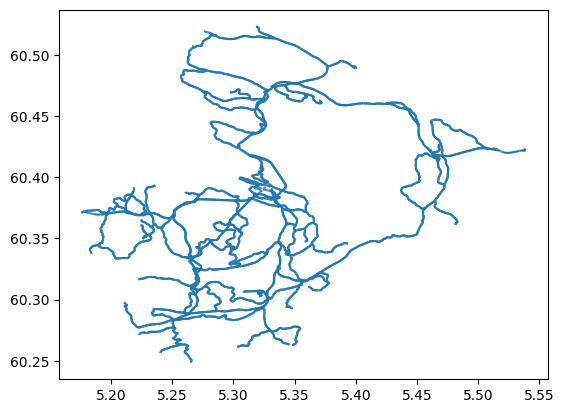

In [252]:
gdf_clean.plot()

<Axes: >

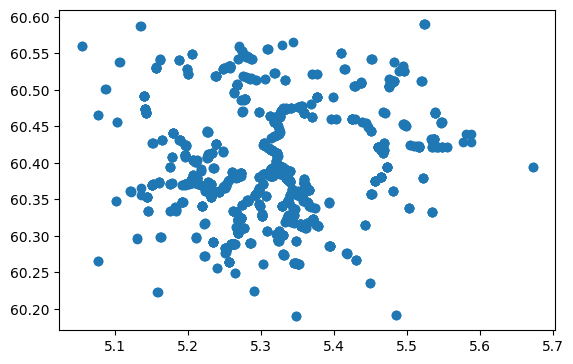

In [157]:
gdf.set_geometry('geometry_extreme_points').plot()

#### Folium

In [158]:
ps = []

for i in range(len(gdf_clean)):
    ps_aux = []
    for p in gdf_clean['geometry_line'].iloc[i].geoms:
        ps_aux.append([p.coords.xy[1][0], p.coords.xy[0][0]])

    ps.append(ps_aux)

In [159]:
map_ = folium.Map(location=[60.397076, 5.324383], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(ps)+1):
    folium.PolyLine(ps[point-1], color='blue', weight=1).add_to(map_)

In [253]:
map_